## Import

In [1]:
import pandas as pd
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import optuna
import shap
from sklearn.feature_selection import SelectFromModel
from functools import partial
from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter("ignore")

In [2]:
train = pd.read_csv(r"C:\work\Чемпионат_Оренбург/train_dataset_train.csv")

In [3]:
test = pd.read_csv(r"C:\work\Чемпионат_Оренбург/test_dataset_test.csv")

In [4]:
sub = pd.read_csv(r"C:\work\Чемпионат_Оренбург\Оренбург/sample_solution.csv")

In [5]:
train.dtypes.value_counts()

float64    38
int64      11
object     10
dtype: int64

In [6]:
train.target.value_counts()

0    174301
1     13512
5      3678
4      3659
3      3027
2      1823
Name: target, dtype: int64

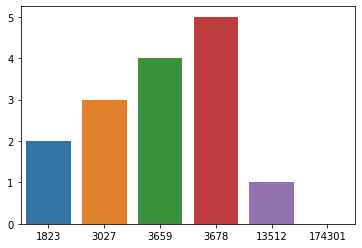

In [7]:
sns.barplot(y=train["target"].value_counts().index,x=train["target"].value_counts().values);

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 59 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         200000 non-null  int64  
 1   age_indicator              159123 non-null  float64
 2   month_id                   200000 non-null  object 
 3   student_id                 200000 non-null  int64  
 4   program_id                 200000 non-null  int64  
 5   carts_created_at           200000 non-null  object 
 6   spent_time_total           86309 non-null   float64
 7   spent_time_to_complete_hw  42467 non-null   float64
 8   completed_hw               97599 non-null   float64
 9   failed_hw                  97599 non-null   float64
 10  reworked_hw                97599 non-null   float64
 11  interacted_hw              97599 non-null   float64
 12  avg_hw_mark                44496 non-null   float64
 13  test_with_good_mark        97

In [9]:
train.nunique()

id                           200000
age_indicator                    40
month_id                         18
student_id                    31153
program_id                      267
carts_created_at                447
spent_time_total                945
spent_time_to_complete_hw         2
completed_hw                     20
failed_hw                        36
reworked_hw                     216
interacted_hw                    23
avg_hw_mark                      74
test_with_good_mark              83
test_with_great_mark             59
webinars                         62
avg_quiz_result                2608
notes                           311
hw_leader                        49
lessons                          62
activity                        140
bought_d1                        10
bought_d2                         4
bought_d3                         6
bought_d4                         4
bought_d5                         5
bought_avg_duration             158
payment_type                

In [10]:
test.nunique()

id                           84997
age_indicator                   40
month_id                        18
student_id                   26833
program_id                     261
carts_created_at               447
spent_time_total               800
spent_time_to_complete_hw        2
completed_hw                    18
failed_hw                       32
reworked_hw                    165
interacted_hw                   19
avg_hw_mark                     42
test_with_good_mark             74
test_with_great_mark            52
webinars                        57
avg_quiz_result               1336
notes                          234
hw_leader                       44
lessons                         56
activity                       122
bought_d1                        9
bought_d2                        4
bought_d3                        6
bought_d4                        4
bought_d5                        5
bought_avg_duration            154
payment_type                     2
promo               

In [11]:
idx = train.shape[0]
data = pd.concat([train, test], sort=False)

In [12]:
data['age_indicator'].fillna(data['age_indicator'].median(), inplace=True)

In [13]:
data['carts_created_at']=data['carts_created_at'].str.replace('/','.')
data['month_id']=data['month_id'].str.replace('/','.')

In [14]:
data['time_1'] = data[['carts_created_at']].apply(pd.to_datetime)
data['time_2'] = data[['month_id']].apply(pd.to_datetime)

In [15]:
data['time_day']=(data['time_2']-data['time_1']).dt.days

In [16]:
data['price_day']=data['price']/data['time_day']

In [17]:
#data['total_day']=(data['time_day']/365)*100

In [18]:
data = data.fillna(0)

In [19]:
categorial=['month_id','city','country','os','browser','platform','communication_type','ABC','promo','carts_created_at']

In [20]:
for i in categorial:
        data[i] = data[i].astype('category')
        data[i] = data[i].cat.codes
        data[i] = data[i].astype('int')
  
        

In [21]:
data.price_day=data.price_day.replace(np.inf,0)

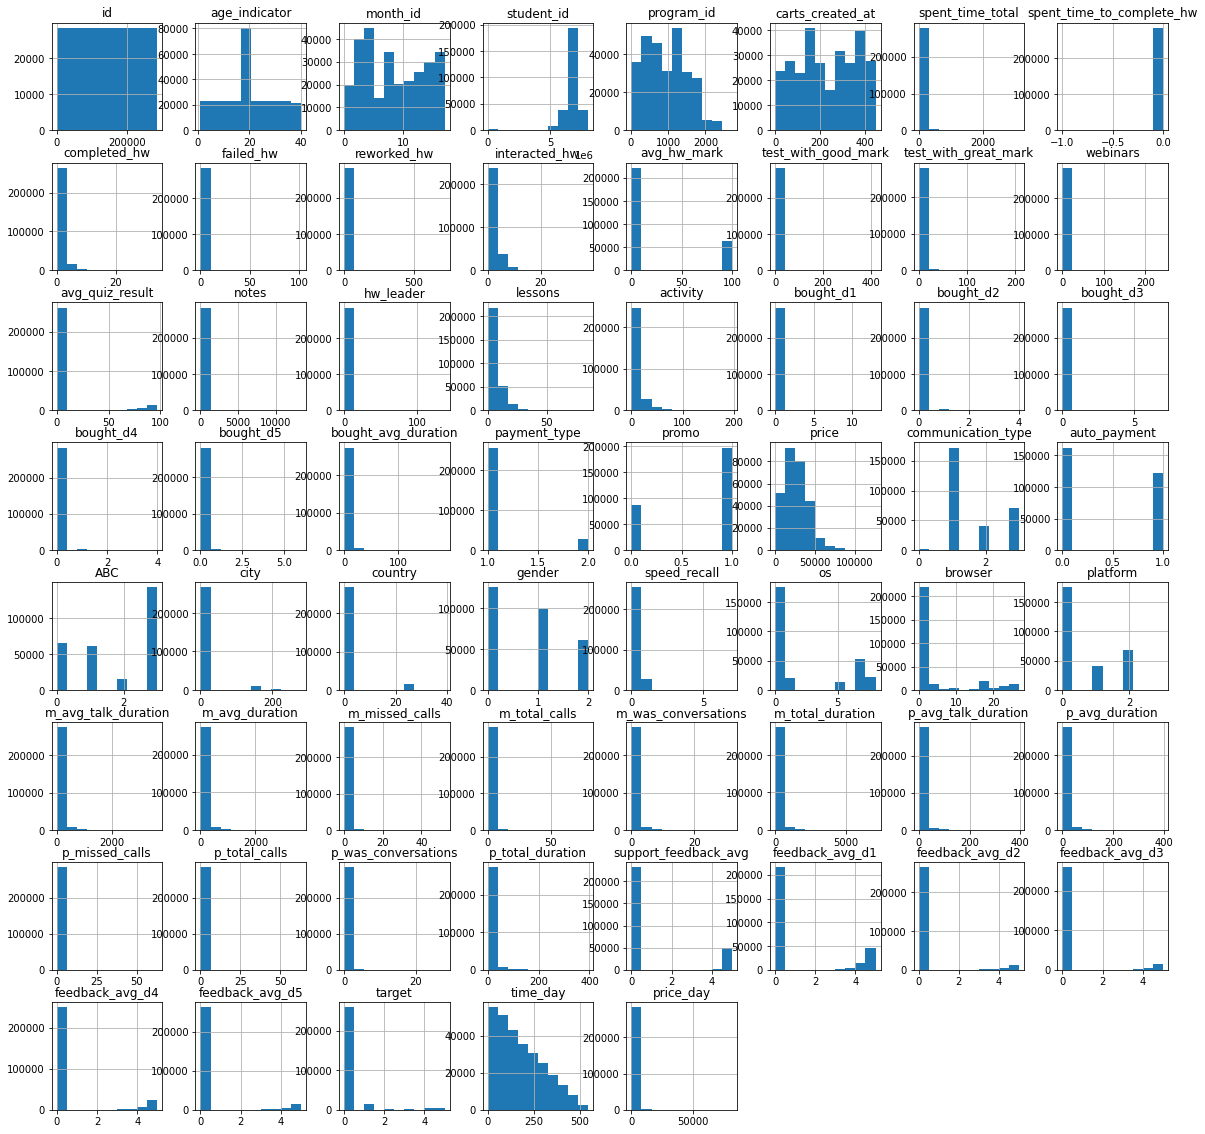

In [22]:
data.hist(figsize=(20,20))
plt.show()

<AxesSubplot:>

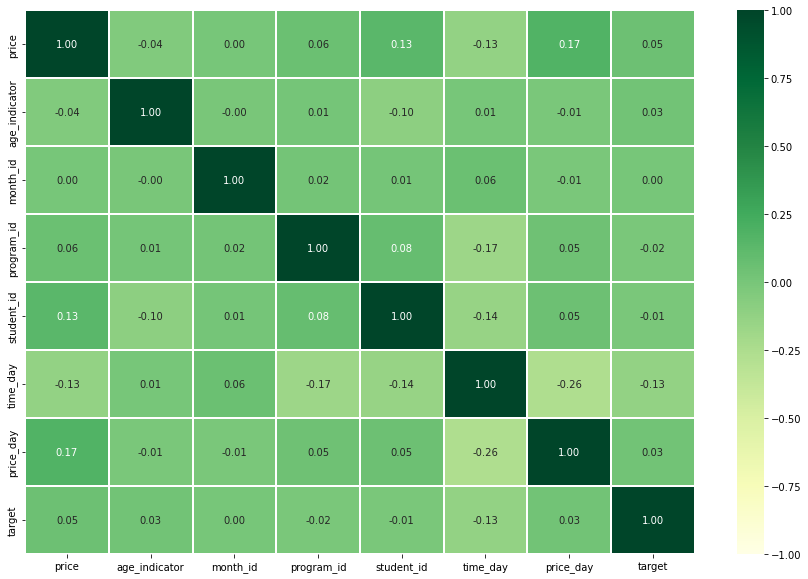

In [24]:
plt.figure(figsize=(15, 10))
sns.heatmap(data[['price','age_indicator','month_id','program_id','student_id','time_day','price_day','target',]].corr(), annot = True, cmap = 'YlGn', fmt=".2f", vmin = -1, vmax = 1, linewidths = 0.1, linecolor = 'white')

In [22]:
data_train = data[:idx]
data_test = data[idx:]

In [23]:
X = data_train.drop(['time_1','time_2','target'], axis = 1)
y= data_train[["target"]].values
X_valid = data_test.drop(['time_1','time_2','target'], axis = 1)

In [39]:
sc = ('Scaler', StandardScaler())
est =[]
est.append(('RandomForestClassifier', Pipeline([sc, ('RandomForestClassifier', RandomForestClassifier())])))
est.append(('XGBClassifier', Pipeline([('XGBClassifier', XGBClassifier())])))
est.append(('RidgeClassifier', Pipeline([sc,('RidgeClassifier', RidgeClassifier())])))
est.append(('LogisticRegression', Pipeline([sc, ('LogisticRegression', LogisticRegression(multi_class='multinomial'))])))

In [40]:
seed = 42
splits = 3
models_score ={}
for i in est:
    kfold = KFold(n_splits=splits, random_state=seed, shuffle=True)
    results = cross_val_score(i[1],X, y, cv=kfold)
    models_score.update({i[0] : results.mean()})
    
sorted(models_score.items(), key= lambda v:v[1], reverse=True)

[('RandomForestClassifier', 0.9025499953951045),
 ('XGBClassifier', 0.9000049984449925),
 ('RidgeClassifier', 0.8717399932935535),
 ('LogisticRegression', 0.8714099939685402)]

In [41]:
future=X.columns

In [171]:
def run(trial, data=X,target=y):
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=7777)
   
    
    params = {  
                 'n_estimators': trial.suggest_int('n_estimators', 1000, 1300),
                  'max_depth': trial.suggest_int('max_depth', 9, 10),
                 'learning_rate': trial.suggest_uniform('learning_rate', 0.005, 0.7),
                 'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
                 'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),            
                
                  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 100),
                  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 100),
              
                
            }
    model = XGBClassifier(**params,nthread=32,use_label_encoder=False,tree_method='gpu_hist')
    model.fit(X_train, y_train,
           eval_set=[(X_train, y_train),(X_valid, y_valid)],eval_metric=['mlogloss'],early_stopping_rounds=50, verbose=50,
           callbacks=[optuna.integration.XGBoostPruningCallback(trial, observation_key='validation_0-mlogloss')],
          )
    y_proba = model.predict(X_valid)
    test_score =0.2* recall_score(y_valid, y_proba, average='macro') + 0.8* precision_score(y_valid,y_proba, average='macro')
    
    return test_score
    

In [172]:
study = optuna.create_study(direction='maximize')
study.optimize(run, n_trials=50)

[I 2022-08-03 20:38:24,419] A new study created in memory with name: no-name-e9c0c204-1ec7-4664-bab2-ce408bc763cf
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.



[0]	validation_0-mlogloss:1.14440	validation_1-mlogloss:1.15168
[50]	validation_0-mlogloss:0.13595	validation_1-mlogloss:0.21499
[100]	validation_0-mlogloss:0.06898	validation_1-mlogloss:0.16099
[150]	validation_0-mlogloss:0.03759	validation_1-mlogloss:0.13191
[200]	validation_0-mlogloss:0.02247	validation_1-mlogloss:0.11815
[250]	validation_0-mlogloss:0.01375	validation_1-mlogloss:0.10956
[300]	validation_0-mlogloss:0.00912	validation_1-mlogloss:0.10538
[350]	validation_0-mlogloss:0.00650	validation_1-mlogloss:0.10315
[400]	validation_0-mlogloss:0.00483	validation_1-mlogloss:0.10143
[450]	validation_0-mlogloss:0.00372	validation_1-mlogloss:0.10061
[500]	validation_0-mlogloss:0.00298	validation_1-mlogloss:0.10037
[550]	validation_0-mlogloss:0.00246	validation_1-mlogloss:0.10044
[600]	validation_0-mlogloss:0.00206	validation_1-mlogloss:0.10051
[611]	validation_0-mlogloss:0.00200	validation_1-mlogloss:0.10048


[I 2022-08-03 20:39:58,932] Trial 0 finished with value: 0.9273540806836547 and parameters: {'n_estimators': 1291, 'max_depth': 9, 'learning_rate': 0.31297321970563313, 'subsample': 1.0, 'colsample_bylevel': 0.8, 'reg_lambda': 0.20517224524396982, 'reg_alpha': 0.026602415025049536}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-l

[0]	validation_0-mlogloss:0.74540	validation_1-mlogloss:0.75780
[50]	validation_0-mlogloss:0.06789	validation_1-mlogloss:0.16964
[100]	validation_0-mlogloss:0.02086	validation_1-mlogloss:0.13040
[150]	validation_0-mlogloss:0.00909	validation_1-mlogloss:0.11998
[200]	validation_0-mlogloss:0.00513	validation_1-mlogloss:0.11747
[250]	validation_0-mlogloss:0.00338	validation_1-mlogloss:0.11730
[288]	validation_0-mlogloss:0.00266	validation_1-mlogloss:0.11737


[I 2022-08-03 20:40:49,749] Trial 1 finished with value: 0.9159084036339008 and parameters: {'n_estimators': 1129, 'max_depth': 9, 'learning_rate': 0.5979353003733764, 'subsample': 0.8, 'colsample_bylevel': 0.8, 'reg_lambda': 0.8364067519700136, 'reg_alpha': 0.03642600579383272}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-lear

[0]	validation_0-mlogloss:1.59900	validation_1-mlogloss:1.60046
[50]	validation_0-mlogloss:0.29131	validation_1-mlogloss:0.33787
[100]	validation_0-mlogloss:0.20341	validation_1-mlogloss:0.26951
[150]	validation_0-mlogloss:0.15902	validation_1-mlogloss:0.23503
[200]	validation_0-mlogloss:0.12496	validation_1-mlogloss:0.20908
[250]	validation_0-mlogloss:0.10015	validation_1-mlogloss:0.19010
[300]	validation_0-mlogloss:0.08158	validation_1-mlogloss:0.17594
[350]	validation_0-mlogloss:0.06683	validation_1-mlogloss:0.16402
[400]	validation_0-mlogloss:0.05600	validation_1-mlogloss:0.15553
[450]	validation_0-mlogloss:0.04683	validation_1-mlogloss:0.14837
[500]	validation_0-mlogloss:0.03972	validation_1-mlogloss:0.14224
[550]	validation_0-mlogloss:0.03367	validation_1-mlogloss:0.13720
[600]	validation_0-mlogloss:0.02904	validation_1-mlogloss:0.13314
[650]	validation_0-mlogloss:0.02522	validation_1-mlogloss:0.12993
[700]	validation_0-mlogloss:0.02218	validation_1-mlogloss:0.12729
[750]	validat

[I 2022-08-03 20:45:13,052] Trial 2 finished with value: 0.910441053041654 and parameters: {'n_estimators': 1023, 'max_depth': 10, 'learning_rate': 0.08585809843630281, 'subsample': 0.7, 'colsample_bylevel': 0.6, 'reg_lambda': 4.120685587991366, 'reg_alpha': 0.0017975367372769896}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-le

[0]	validation_0-mlogloss:1.37299	validation_1-mlogloss:1.37484
[50]	validation_0-mlogloss:0.33839	validation_1-mlogloss:0.36636
[100]	validation_0-mlogloss:0.29714	validation_1-mlogloss:0.33608
[150]	validation_0-mlogloss:0.27514	validation_1-mlogloss:0.32054
[200]	validation_0-mlogloss:0.26120	validation_1-mlogloss:0.31062
[250]	validation_0-mlogloss:0.25062	validation_1-mlogloss:0.30351
[300]	validation_0-mlogloss:0.24204	validation_1-mlogloss:0.29722
[350]	validation_0-mlogloss:0.23496	validation_1-mlogloss:0.29242
[400]	validation_0-mlogloss:0.22874	validation_1-mlogloss:0.28799
[450]	validation_0-mlogloss:0.22402	validation_1-mlogloss:0.28463
[500]	validation_0-mlogloss:0.21966	validation_1-mlogloss:0.28153
[550]	validation_0-mlogloss:0.21587	validation_1-mlogloss:0.27884
[600]	validation_0-mlogloss:0.21252	validation_1-mlogloss:0.27648
[650]	validation_0-mlogloss:0.20968	validation_1-mlogloss:0.27447
[700]	validation_0-mlogloss:0.20689	validation_1-mlogloss:0.27261
[750]	validat

[I 2022-08-03 20:46:32,464] Trial 3 finished with value: 0.7402093012505893 and parameters: {'n_estimators': 1208, 'max_depth': 10, 'learning_rate': 0.19830666266888286, 'subsample': 0.9, 'colsample_bylevel': 0.6, 'reg_lambda': 0.9581474631275095, 'reg_alpha': 35.09966874374019}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-lear

[0]	validation_0-mlogloss:1.25331	validation_1-mlogloss:1.26055
[50]	validation_0-mlogloss:0.11379	validation_1-mlogloss:0.19823
[100]	validation_0-mlogloss:0.04891	validation_1-mlogloss:0.14295
[150]	validation_0-mlogloss:0.02418	validation_1-mlogloss:0.12092
[200]	validation_0-mlogloss:0.01311	validation_1-mlogloss:0.10988
[250]	validation_0-mlogloss:0.00804	validation_1-mlogloss:0.10441
[300]	validation_0-mlogloss:0.00543	validation_1-mlogloss:0.10206
[350]	validation_0-mlogloss:0.00406	validation_1-mlogloss:0.10106
[400]	validation_0-mlogloss:0.00320	validation_1-mlogloss:0.10064
[450]	validation_0-mlogloss:0.00266	validation_1-mlogloss:0.10055
[500]	validation_0-mlogloss:0.00227	validation_1-mlogloss:0.10054
[533]	validation_0-mlogloss:0.00207	validation_1-mlogloss:0.10062


[I 2022-08-03 20:48:32,093] Trial 4 finished with value: 0.9263493033289019 and parameters: {'n_estimators': 1284, 'max_depth': 10, 'learning_rate': 0.2503262908832366, 'subsample': 0.9, 'colsample_bylevel': 0.8, 'reg_lambda': 0.0165148138833241, 'reg_alpha': 0.12976661213023596}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-lea

[0]	validation_0-mlogloss:1.19240	validation_1-mlogloss:1.19544


[I 2022-08-03 20:48:34,295] Trial 7 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.



[0]	validation_0-mlogloss:0.94999	validation_1-mlogloss:0.95439


[I 2022-08-03 20:48:34,952] Trial 8 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.

[I 2022-08-03 20:48:35,582] Trial 9 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` m

[0]	validation_0-mlogloss:1.59495	validation_1-mlogloss:1.59570
[50]	validation_0-mlogloss:0.39272	validation_1-mlogloss:0.40935
[100]	validation_0-mlogloss:0.34434	validation_1-mlogloss:0.37111
[150]	validation_0-mlogloss:0.31541	validation_1-mlogloss:0.35105
[200]	validation_0-mlogloss:0.29121	validation_1-mlogloss:0.33491
[250]	validation_0-mlogloss:0.27115	validation_1-mlogloss:0.32222
[300]	validation_0-mlogloss:0.25339	validation_1-mlogloss:0.31108
[350]	validation_0-mlogloss:0.23793	validation_1-mlogloss:0.30185
[400]	validation_0-mlogloss:0.22421	validation_1-mlogloss:0.29340
[450]	validation_0-mlogloss:0.21172	validation_1-mlogloss:0.28554
[500]	validation_0-mlogloss:0.20020	validation_1-mlogloss:0.27856
[550]	validation_0-mlogloss:0.18967	validation_1-mlogloss:0.27209
[600]	validation_0-mlogloss:0.18003	validation_1-mlogloss:0.26584
[650]	validation_0-mlogloss:0.17138	validation_1-mlogloss:0.26044
[700]	validation_0-mlogloss:0.16309	validation_1-mlogloss:0.25543
[750]	validat

[I 2022-08-03 20:53:15,435] Trial 10 finished with value: 0.8163061269664831 and parameters: {'n_estimators': 1184, 'max_depth': 9, 'learning_rate': 0.09151825116103024, 'subsample': 0.4, 'colsample_bylevel': 0.5, 'reg_lambda': 86.28433362454979, 'reg_alpha': 1.1063167188934584}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-lear

[0]	validation_0-mlogloss:1.36563	validation_1-mlogloss:1.37030
[50]	validation_0-mlogloss:0.17712	validation_1-mlogloss:0.24721
[100]	validation_0-mlogloss:0.10399	validation_1-mlogloss:0.18751
[150]	validation_0-mlogloss:0.06507	validation_1-mlogloss:0.15473
[200]	validation_0-mlogloss:0.04145	validation_1-mlogloss:0.13380
[250]	validation_0-mlogloss:0.02782	validation_1-mlogloss:0.12113
[300]	validation_0-mlogloss:0.01934	validation_1-mlogloss:0.11297
[350]	validation_0-mlogloss:0.01358	validation_1-mlogloss:0.10763
[400]	validation_0-mlogloss:0.00992	validation_1-mlogloss:0.10382
[450]	validation_0-mlogloss:0.00748	validation_1-mlogloss:0.10174
[500]	validation_0-mlogloss:0.00589	validation_1-mlogloss:0.10010
[550]	validation_0-mlogloss:0.00478	validation_1-mlogloss:0.09918
[600]	validation_0-mlogloss:0.00397	validation_1-mlogloss:0.09865
[650]	validation_0-mlogloss:0.00339	validation_1-mlogloss:0.09836
[700]	validation_0-mlogloss:0.00294	validation_1-mlogloss:0.09825
[750]	validat

[I 2022-08-03 20:55:43,901] Trial 11 finished with value: 0.9259178781935213 and parameters: {'n_estimators': 1291, 'max_depth': 9, 'learning_rate': 0.19543574075908532, 'subsample': 0.9, 'colsample_bylevel': 0.9, 'reg_lambda': 0.013100680491982456, 'reg_alpha': 0.10306108386322044}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-

[0]	validation_0-mlogloss:0.98869	validation_1-mlogloss:0.99828


[I 2022-08-03 20:55:44,702] Trial 12 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.

[I 2022-08-03 20:55:45,485] Trial 13 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit`

[0]	validation_0-mlogloss:1.34168	validation_1-mlogloss:1.34542


[I 2022-08-03 20:55:46,207] Trial 14 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.

[I 2022-08-03 20:55:46,989] Trial 15 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit`

[0]	validation_0-mlogloss:1.67956	validation_1-mlogloss:1.68047
[50]	validation_0-mlogloss:0.41125	validation_1-mlogloss:0.44200
[100]	validation_0-mlogloss:0.28576	validation_1-mlogloss:0.33746
[150]	validation_0-mlogloss:0.23730	validation_1-mlogloss:0.30110
[200]	validation_0-mlogloss:0.20614	validation_1-mlogloss:0.27801
[250]	validation_0-mlogloss:0.18105	validation_1-mlogloss:0.25946
[300]	validation_0-mlogloss:0.16127	validation_1-mlogloss:0.24555
[350]	validation_0-mlogloss:0.14279	validation_1-mlogloss:0.23211
[400]	validation_0-mlogloss:0.12771	validation_1-mlogloss:0.22184
[450]	validation_0-mlogloss:0.11463	validation_1-mlogloss:0.21303
[500]	validation_0-mlogloss:0.10280	validation_1-mlogloss:0.20425
[550]	validation_0-mlogloss:0.09290	validation_1-mlogloss:0.19727
[600]	validation_0-mlogloss:0.08426	validation_1-mlogloss:0.19099
[650]	validation_0-mlogloss:0.07669	validation_1-mlogloss:0.18560
[700]	validation_0-mlogloss:0.06951	validation_1-mlogloss:0.18019
[750]	validat

[I 2022-08-03 20:59:30,802] Trial 16 finished with value: 0.8967602745560722 and parameters: {'n_estimators': 1229, 'max_depth': 9, 'learning_rate': 0.04920529571649118, 'subsample': 0.5, 'colsample_bylevel': 0.4, 'reg_lambda': 0.009502731276522397, 'reg_alpha': 0.0062742014444701405}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with sciki

[0]	validation_0-mlogloss:1.04820	validation_1-mlogloss:1.05788


[I 2022-08-03 20:59:31,836] Trial 17 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.



[0]	validation_0-mlogloss:1.24007	validation_1-mlogloss:1.24381


[I 2022-08-03 20:59:32,530] Trial 18 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.



[0]	validation_0-mlogloss:1.47509	validation_1-mlogloss:1.47634
[50]	validation_0-mlogloss:0.38761	validation_1-mlogloss:0.40297
[100]	validation_0-mlogloss:0.37026	validation_1-mlogloss:0.38845
[150]	validation_0-mlogloss:0.36375	validation_1-mlogloss:0.38338
[200]	validation_0-mlogloss:0.36040	validation_1-mlogloss:0.38074
[250]	validation_0-mlogloss:0.36034	validation_1-mlogloss:0.38070
[252]	validation_0-mlogloss:0.36034	validation_1-mlogloss:0.38070


C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2022-08-03 20:59:48,925] Trial 19 finished with value: 0.518198057731992 and parameters: {'n_estimators': 1055, 'max_depth': 10, 'learning_rate': 0.14837488461957715, 'subsample': 1.0, 'colsample_bylevel': 0.9, 'reg_lambda': 0.35722113488504875, 'reg_alpha': 96.67338226351158}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility w

[0]	validation_0-mlogloss:1.32340	validation_1-mlogloss:1.32861


[I 2022-08-03 20:59:50,712] Trial 21 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.



[0]	validation_0-mlogloss:1.44871	validation_1-mlogloss:1.45244
[50]	validation_0-mlogloss:0.19974	validation_1-mlogloss:0.26477
[100]	validation_0-mlogloss:0.12830	validation_1-mlogloss:0.20739
[150]	validation_0-mlogloss:0.08593	validation_1-mlogloss:0.17287
[200]	validation_0-mlogloss:0.06005	validation_1-mlogloss:0.15062
[250]	validation_0-mlogloss:0.04237	validation_1-mlogloss:0.13458
[300]	validation_0-mlogloss:0.03057	validation_1-mlogloss:0.12398
[350]	validation_0-mlogloss:0.02260	validation_1-mlogloss:0.11625
[400]	validation_0-mlogloss:0.01700	validation_1-mlogloss:0.11090
[450]	validation_0-mlogloss:0.01316	validation_1-mlogloss:0.10702
[500]	validation_0-mlogloss:0.01031	validation_1-mlogloss:0.10465
[550]	validation_0-mlogloss:0.00820	validation_1-mlogloss:0.10248
[600]	validation_0-mlogloss:0.00672	validation_1-mlogloss:0.10118
[650]	validation_0-mlogloss:0.00562	validation_1-mlogloss:0.10054
[700]	validation_0-mlogloss:0.00472	validation_1-mlogloss:0.09970
[750]	validat

[I 2022-08-03 21:02:51,955] Trial 22 finished with value: 0.926646837351568 and parameters: {'n_estimators': 1268, 'max_depth': 9, 'learning_rate': 0.1548012505470977, 'subsample': 0.9, 'colsample_bylevel': 0.9, 'reg_lambda': 0.003617968485056644, 'reg_alpha': 0.10430745859157373}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-le

[0]	validation_0-mlogloss:1.47739	validation_1-mlogloss:1.48073
[50]	validation_0-mlogloss:0.21704	validation_1-mlogloss:0.27860
[100]	validation_0-mlogloss:0.13934	validation_1-mlogloss:0.21602
[150]	validation_0-mlogloss:0.09688	validation_1-mlogloss:0.18172
[200]	validation_0-mlogloss:0.06673	validation_1-mlogloss:0.15559
[250]	validation_0-mlogloss:0.04830	validation_1-mlogloss:0.13907
[300]	validation_0-mlogloss:0.03595	validation_1-mlogloss:0.12763
[350]	validation_0-mlogloss:0.02701	validation_1-mlogloss:0.11987
[400]	validation_0-mlogloss:0.02083	validation_1-mlogloss:0.11339
[450]	validation_0-mlogloss:0.01644	validation_1-mlogloss:0.10913
[500]	validation_0-mlogloss:0.01346	validation_1-mlogloss:0.10601
[550]	validation_0-mlogloss:0.01126	validation_1-mlogloss:0.10378
[600]	validation_0-mlogloss:0.00959	validation_1-mlogloss:0.10207
[650]	validation_0-mlogloss:0.00828	validation_1-mlogloss:0.10083
[700]	validation_0-mlogloss:0.00729	validation_1-mlogloss:0.10005
[750]	validat

[I 2022-08-03 21:06:21,322] Trial 23 finished with value: 0.926758286082049 and parameters: {'n_estimators': 1264, 'max_depth': 9, 'learning_rate': 0.14124782097985328, 'subsample': 0.9, 'colsample_bylevel': 0.9, 'reg_lambda': 0.002729294959775577, 'reg_alpha': 0.434741160422396}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-lea

[0]	validation_0-mlogloss:1.77038	validation_1-mlogloss:1.77061
[50]	validation_0-mlogloss:1.10941	validation_1-mlogloss:1.11790
[100]	validation_0-mlogloss:0.79310	validation_1-mlogloss:0.80745
[150]	validation_0-mlogloss:0.61125	validation_1-mlogloss:0.63071
[200]	validation_0-mlogloss:0.49893	validation_1-mlogloss:0.52315
[250]	validation_0-mlogloss:0.42600	validation_1-mlogloss:0.45492
[300]	validation_0-mlogloss:0.37687	validation_1-mlogloss:0.41031
[350]	validation_0-mlogloss:0.34239	validation_1-mlogloss:0.38008
[400]	validation_0-mlogloss:0.31654	validation_1-mlogloss:0.35794
[450]	validation_0-mlogloss:0.29623	validation_1-mlogloss:0.34117
[500]	validation_0-mlogloss:0.27952	validation_1-mlogloss:0.32780
[550]	validation_0-mlogloss:0.26476	validation_1-mlogloss:0.31605
[600]	validation_0-mlogloss:0.25204	validation_1-mlogloss:0.30582
[650]	validation_0-mlogloss:0.24101	validation_1-mlogloss:0.29677
[700]	validation_0-mlogloss:0.23167	validation_1-mlogloss:0.28919
[750]	validat

[I 2022-08-03 21:11:34,369] Trial 24 finished with value: 0.84823758833284 and parameters: {'n_estimators': 1252, 'max_depth': 9, 'learning_rate': 0.009188097722870964, 'subsample': 0.9, 'colsample_bylevel': 0.9, 'reg_lambda': 0.0020248999755080573, 'reg_alpha': 0.5204693167423035}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-l

[0]	validation_0-mlogloss:1.47449	validation_1-mlogloss:1.47796
[50]	validation_0-mlogloss:0.21180	validation_1-mlogloss:0.27409
[100]	validation_0-mlogloss:0.13842	validation_1-mlogloss:0.21569
[150]	validation_0-mlogloss:0.09668	validation_1-mlogloss:0.18125
[200]	validation_0-mlogloss:0.06802	validation_1-mlogloss:0.15739
[250]	validation_0-mlogloss:0.04923	validation_1-mlogloss:0.13995
[300]	validation_0-mlogloss:0.03649	validation_1-mlogloss:0.12870
[350]	validation_0-mlogloss:0.02774	validation_1-mlogloss:0.12094
[400]	validation_0-mlogloss:0.02115	validation_1-mlogloss:0.11479
[450]	validation_0-mlogloss:0.01641	validation_1-mlogloss:0.11034
[500]	validation_0-mlogloss:0.01283	validation_1-mlogloss:0.10718
[550]	validation_0-mlogloss:0.01036	validation_1-mlogloss:0.10476
[600]	validation_0-mlogloss:0.00854	validation_1-mlogloss:0.10338
[650]	validation_0-mlogloss:0.00706	validation_1-mlogloss:0.10212
[700]	validation_0-mlogloss:0.00596	validation_1-mlogloss:0.10141
[750]	validat

[I 2022-08-03 21:13:54,175] Trial 25 finished with value: 0.9267744222205516 and parameters: {'n_estimators': 1239, 'max_depth': 9, 'learning_rate': 0.14247777131451203, 'subsample': 0.9, 'colsample_bylevel': 0.9, 'reg_lambda': 0.0036920288435831673, 'reg_alpha': 0.0188344222447286}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-

[0]	validation_0-mlogloss:1.51457	validation_1-mlogloss:1.51680
[50]	validation_0-mlogloss:0.26316	validation_1-mlogloss:0.31324
[100]	validation_0-mlogloss:0.18187	validation_1-mlogloss:0.25186
[150]	validation_0-mlogloss:0.13591	validation_1-mlogloss:0.21726
[200]	validation_0-mlogloss:0.10621	validation_1-mlogloss:0.19541
[250]	validation_0-mlogloss:0.08581	validation_1-mlogloss:0.17981
[300]	validation_0-mlogloss:0.07129	validation_1-mlogloss:0.16825
[350]	validation_0-mlogloss:0.06048	validation_1-mlogloss:0.16002
[400]	validation_0-mlogloss:0.05252	validation_1-mlogloss:0.15413
[450]	validation_0-mlogloss:0.04619	validation_1-mlogloss:0.14933
[500]	validation_0-mlogloss:0.04132	validation_1-mlogloss:0.14520
[550]	validation_0-mlogloss:0.03752	validation_1-mlogloss:0.14242
[600]	validation_0-mlogloss:0.03437	validation_1-mlogloss:0.14016
[650]	validation_0-mlogloss:0.03185	validation_1-mlogloss:0.13806
[700]	validation_0-mlogloss:0.02967	validation_1-mlogloss:0.13637
[750]	validat

[I 2022-08-03 21:17:13,867] Trial 26 finished with value: 0.8990555150616097 and parameters: {'n_estimators': 1162, 'max_depth': 9, 'learning_rate': 0.125091952498079, 'subsample': 0.6, 'colsample_bylevel': 0.9, 'reg_lambda': 0.0010071302654548933, 'reg_alpha': 2.3620263040060356}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-le

[0]	validation_0-mlogloss:1.72208	validation_1-mlogloss:1.72269
[50]	validation_0-mlogloss:0.56578	validation_1-mlogloss:0.58756
[100]	validation_0-mlogloss:0.35528	validation_1-mlogloss:0.39276
[150]	validation_0-mlogloss:0.28326	validation_1-mlogloss:0.33349
[200]	validation_0-mlogloss:0.24340	validation_1-mlogloss:0.30261
[250]	validation_0-mlogloss:0.21631	validation_1-mlogloss:0.28163
[300]	validation_0-mlogloss:0.19604	validation_1-mlogloss:0.26638
[350]	validation_0-mlogloss:0.17862	validation_1-mlogloss:0.25336
[400]	validation_0-mlogloss:0.16375	validation_1-mlogloss:0.24216
[450]	validation_0-mlogloss:0.15035	validation_1-mlogloss:0.23228
[500]	validation_0-mlogloss:0.13812	validation_1-mlogloss:0.22296
[550]	validation_0-mlogloss:0.12745	validation_1-mlogloss:0.21524
[600]	validation_0-mlogloss:0.11747	validation_1-mlogloss:0.20778
[650]	validation_0-mlogloss:0.10907	validation_1-mlogloss:0.20151
[700]	validation_0-mlogloss:0.10108	validation_1-mlogloss:0.19562
[750]	validat

[I 2022-08-03 21:21:26,930] Trial 27 finished with value: 0.891547003843691 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'learning_rate': 0.030192807754922057, 'subsample': 0.5, 'colsample_bylevel': 0.9, 'reg_lambda': 0.0034807890608535698, 'reg_alpha': 0.017423344100808903}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with sciki

[0]	validation_0-mlogloss:1.08350	validation_1-mlogloss:1.08742


[I 2022-08-03 21:21:27,698] Trial 28 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.



[0]	validation_0-mlogloss:1.61943	validation_1-mlogloss:1.62091
[50]	validation_0-mlogloss:0.31763	validation_1-mlogloss:0.36008
[100]	validation_0-mlogloss:0.22777	validation_1-mlogloss:0.28852
[150]	validation_0-mlogloss:0.18280	validation_1-mlogloss:0.25195
[200]	validation_0-mlogloss:0.15153	validation_1-mlogloss:0.22845
[250]	validation_0-mlogloss:0.12625	validation_1-mlogloss:0.21005
[300]	validation_0-mlogloss:0.10596	validation_1-mlogloss:0.19385
[350]	validation_0-mlogloss:0.08863	validation_1-mlogloss:0.18002
[400]	validation_0-mlogloss:0.07563	validation_1-mlogloss:0.16984
[450]	validation_0-mlogloss:0.06494	validation_1-mlogloss:0.16134
[500]	validation_0-mlogloss:0.05591	validation_1-mlogloss:0.15379
[550]	validation_0-mlogloss:0.04862	validation_1-mlogloss:0.14799
[600]	validation_0-mlogloss:0.04233	validation_1-mlogloss:0.14235
[650]	validation_0-mlogloss:0.03720	validation_1-mlogloss:0.13810
[700]	validation_0-mlogloss:0.03266	validation_1-mlogloss:0.13378
[750]	validat

[I 2022-08-03 21:24:43,951] Trial 29 finished with value: 0.9143796294169614 and parameters: {'n_estimators': 1123, 'max_depth': 9, 'learning_rate': 0.0762823683491904, 'subsample': 0.8, 'colsample_bylevel': 0.4, 'reg_lambda': 0.21486979724315203, 'reg_alpha': 0.38510763743270165}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-le

[0]	validation_0-mlogloss:1.49470	validation_1-mlogloss:1.49781
[50]	validation_0-mlogloss:0.22805	validation_1-mlogloss:0.28680
[100]	validation_0-mlogloss:0.15214	validation_1-mlogloss:0.22629
[150]	validation_0-mlogloss:0.10951	validation_1-mlogloss:0.19230
[200]	validation_0-mlogloss:0.07935	validation_1-mlogloss:0.16769
[250]	validation_0-mlogloss:0.05886	validation_1-mlogloss:0.15106
[300]	validation_0-mlogloss:0.04457	validation_1-mlogloss:0.13947
[350]	validation_0-mlogloss:0.03384	validation_1-mlogloss:0.12960
[400]	validation_0-mlogloss:0.02650	validation_1-mlogloss:0.12315
[450]	validation_0-mlogloss:0.02110	validation_1-mlogloss:0.11809
[500]	validation_0-mlogloss:0.01691	validation_1-mlogloss:0.11453
[550]	validation_0-mlogloss:0.01381	validation_1-mlogloss:0.11198
[600]	validation_0-mlogloss:0.01150	validation_1-mlogloss:0.10965
[650]	validation_0-mlogloss:0.00971	validation_1-mlogloss:0.10838
[700]	validation_0-mlogloss:0.00830	validation_1-mlogloss:0.10719
[750]	validat

[I 2022-08-03 21:27:53,598] Trial 30 finished with value: 0.9230879677609882 and parameters: {'n_estimators': 1270, 'max_depth': 9, 'learning_rate': 0.13323196849667177, 'subsample': 0.8, 'colsample_bylevel': 1.0, 'reg_lambda': 0.6077790078159315, 'reg_alpha': 0.030446454724002474}. Best is trial 0 with value: 0.9273540806836547.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-l

[0]	validation_0-mlogloss:1.44269	validation_1-mlogloss:1.44650


[I 2022-08-03 21:27:54,336] Trial 31 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.



[0]	validation_0-mlogloss:1.54717	validation_1-mlogloss:1.54983
[50]	validation_0-mlogloss:0.24626	validation_1-mlogloss:0.30209
[100]	validation_0-mlogloss:0.16760	validation_1-mlogloss:0.23801
[150]	validation_0-mlogloss:0.12606	validation_1-mlogloss:0.20475
[200]	validation_0-mlogloss:0.09644	validation_1-mlogloss:0.18077
[250]	validation_0-mlogloss:0.07397	validation_1-mlogloss:0.16200
[300]	validation_0-mlogloss:0.05806	validation_1-mlogloss:0.14779
[350]	validation_0-mlogloss:0.04562	validation_1-mlogloss:0.13692
[400]	validation_0-mlogloss:0.03653	validation_1-mlogloss:0.12879
[450]	validation_0-mlogloss:0.02933	validation_1-mlogloss:0.12249
[500]	validation_0-mlogloss:0.02413	validation_1-mlogloss:0.11780
[550]	validation_0-mlogloss:0.01963	validation_1-mlogloss:0.11362
[600]	validation_0-mlogloss:0.01633	validation_1-mlogloss:0.11025
[650]	validation_0-mlogloss:0.01368	validation_1-mlogloss:0.10772
[700]	validation_0-mlogloss:0.01141	validation_1-mlogloss:0.10516
[750]	validat

[I 2022-08-03 21:30:52,138] Trial 32 finished with value: 0.9278230740575764 and parameters: {'n_estimators': 1238, 'max_depth': 9, 'learning_rate': 0.10846692523927018, 'subsample': 0.9, 'colsample_bylevel': 0.9, 'reg_lambda': 0.004688748882647761, 'reg_alpha': 0.009825482290623943}. Best is trial 32 with value: 0.9278230740575764.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with sciki

[0]	validation_0-mlogloss:1.54862	validation_1-mlogloss:1.55157
[50]	validation_0-mlogloss:0.24851	validation_1-mlogloss:0.30546
[100]	validation_0-mlogloss:0.16818	validation_1-mlogloss:0.24212
[150]	validation_0-mlogloss:0.12478	validation_1-mlogloss:0.20873
[200]	validation_0-mlogloss:0.09404	validation_1-mlogloss:0.18384
[250]	validation_0-mlogloss:0.07185	validation_1-mlogloss:0.16627
[300]	validation_0-mlogloss:0.05625	validation_1-mlogloss:0.15357
[350]	validation_0-mlogloss:0.04438	validation_1-mlogloss:0.14366
[400]	validation_0-mlogloss:0.03539	validation_1-mlogloss:0.13631
[450]	validation_0-mlogloss:0.02866	validation_1-mlogloss:0.13058
[500]	validation_0-mlogloss:0.02339	validation_1-mlogloss:0.12619
[550]	validation_0-mlogloss:0.01908	validation_1-mlogloss:0.12252
[600]	validation_0-mlogloss:0.01591	validation_1-mlogloss:0.11996
[650]	validation_0-mlogloss:0.01329	validation_1-mlogloss:0.11752
[700]	validation_0-mlogloss:0.01133	validation_1-mlogloss:0.11568
[750]	validat

[I 2022-08-03 21:33:50,476] Trial 33 finished with value: 0.9170157685324553 and parameters: {'n_estimators': 1211, 'max_depth': 9, 'learning_rate': 0.1078497794291817, 'subsample': 0.7, 'colsample_bylevel': 0.9, 'reg_lambda': 0.0017114837610517613, 'reg_alpha': 0.005835925732366542}. Best is trial 32 with value: 0.9278230740575764.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with sciki

[0]	validation_0-mlogloss:1.64491	validation_1-mlogloss:1.64640
[50]	validation_0-mlogloss:0.33238	validation_1-mlogloss:0.37216
[100]	validation_0-mlogloss:0.22531	validation_1-mlogloss:0.28535
[150]	validation_0-mlogloss:0.18145	validation_1-mlogloss:0.24869
[200]	validation_0-mlogloss:0.15132	validation_1-mlogloss:0.22392
[250]	validation_0-mlogloss:0.12856	validation_1-mlogloss:0.20613
[300]	validation_0-mlogloss:0.10908	validation_1-mlogloss:0.19007
[350]	validation_0-mlogloss:0.09417	validation_1-mlogloss:0.17781
[400]	validation_0-mlogloss:0.08124	validation_1-mlogloss:0.16663
[450]	validation_0-mlogloss:0.06973	validation_1-mlogloss:0.15689
[500]	validation_0-mlogloss:0.06050	validation_1-mlogloss:0.14912
[550]	validation_0-mlogloss:0.05287	validation_1-mlogloss:0.14230
[600]	validation_0-mlogloss:0.04596	validation_1-mlogloss:0.13616
[650]	validation_0-mlogloss:0.04029	validation_1-mlogloss:0.13117
[700]	validation_0-mlogloss:0.03544	validation_1-mlogloss:0.12678
[750]	validat

[I 2022-08-03 21:37:25,233] Trial 35 finished with value: 0.9253499462162056 and parameters: {'n_estimators': 1251, 'max_depth': 9, 'learning_rate': 0.06410924508847152, 'subsample': 0.9, 'colsample_bylevel': 0.8, 'reg_lambda': 0.0054822349374304335, 'reg_alpha': 0.0018409659135511026}. Best is trial 32 with value: 0.9278230740575764.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with sci

[0]	validation_0-mlogloss:1.14012	validation_1-mlogloss:1.14753


[I 2022-08-03 21:37:26,104] Trial 36 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.



[0]	validation_0-mlogloss:1.39748	validation_1-mlogloss:1.40157


[I 2022-08-03 21:37:26,790] Trial 37 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.

[I 2022-08-03 21:37:27,541] Trial 38 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit`

[0]	validation_0-mlogloss:1.55168	validation_1-mlogloss:1.55400
[50]	validation_0-mlogloss:0.26497	validation_1-mlogloss:0.31639
[100]	validation_0-mlogloss:0.19596	validation_1-mlogloss:0.26044
[150]	validation_0-mlogloss:0.15646	validation_1-mlogloss:0.22847
[200]	validation_0-mlogloss:0.12653	validation_1-mlogloss:0.20399
[250]	validation_0-mlogloss:0.10479	validation_1-mlogloss:0.18737
[300]	validation_0-mlogloss:0.08615	validation_1-mlogloss:0.17154
[350]	validation_0-mlogloss:0.07235	validation_1-mlogloss:0.15945
[400]	validation_0-mlogloss:0.06038	validation_1-mlogloss:0.14838
[450]	validation_0-mlogloss:0.05170	validation_1-mlogloss:0.14077
[500]	validation_0-mlogloss:0.04416	validation_1-mlogloss:0.13426
[550]	validation_0-mlogloss:0.03786	validation_1-mlogloss:0.12851
[600]	validation_0-mlogloss:0.03310	validation_1-mlogloss:0.12431
[650]	validation_0-mlogloss:0.02865	validation_1-mlogloss:0.12020
[700]	validation_0-mlogloss:0.02463	validation_1-mlogloss:0.11640
[750]	validat

[I 2022-08-03 21:40:49,268] Trial 40 finished with value: 0.9268202564717561 and parameters: {'n_estimators': 1241, 'max_depth': 9, 'learning_rate': 0.106968234555816, 'subsample': 1.0, 'colsample_bylevel': 0.9, 'reg_lambda': 1.6897288245819668, 'reg_alpha': 0.002494337719659516}. Best is trial 32 with value: 0.9278230740575764.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-le

[0]	validation_0-mlogloss:1.55460	validation_1-mlogloss:1.55689
[50]	validation_0-mlogloss:0.26699	validation_1-mlogloss:0.31730
[100]	validation_0-mlogloss:0.19676	validation_1-mlogloss:0.25993
[150]	validation_0-mlogloss:0.15512	validation_1-mlogloss:0.22659
[200]	validation_0-mlogloss:0.12753	validation_1-mlogloss:0.20534
[250]	validation_0-mlogloss:0.10469	validation_1-mlogloss:0.18751
[300]	validation_0-mlogloss:0.08590	validation_1-mlogloss:0.17166
[350]	validation_0-mlogloss:0.07095	validation_1-mlogloss:0.15820
[400]	validation_0-mlogloss:0.05972	validation_1-mlogloss:0.14858
[450]	validation_0-mlogloss:0.05078	validation_1-mlogloss:0.14069
[500]	validation_0-mlogloss:0.04339	validation_1-mlogloss:0.13378
[550]	validation_0-mlogloss:0.03731	validation_1-mlogloss:0.12859
[600]	validation_0-mlogloss:0.03185	validation_1-mlogloss:0.12339
[650]	validation_0-mlogloss:0.02796	validation_1-mlogloss:0.11983
[700]	validation_0-mlogloss:0.02465	validation_1-mlogloss:0.11666
[750]	validat

[I 2022-08-03 21:44:09,669] Trial 41 finished with value: 0.9257341392250195 and parameters: {'n_estimators': 1246, 'max_depth': 9, 'learning_rate': 0.10560064122336561, 'subsample': 1.0, 'colsample_bylevel': 0.9, 'reg_lambda': 1.6386241899488823, 'reg_alpha': 0.002446293263733956}. Best is trial 32 with value: 0.9278230740575764.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-

[0]	validation_0-mlogloss:1.69482	validation_1-mlogloss:1.69558
[50]	validation_0-mlogloss:0.45945	validation_1-mlogloss:0.48150
[100]	validation_0-mlogloss:0.31772	validation_1-mlogloss:0.35482
[150]	validation_0-mlogloss:0.26618	validation_1-mlogloss:0.31358
[200]	validation_0-mlogloss:0.23836	validation_1-mlogloss:0.29209
[250]	validation_0-mlogloss:0.21925	validation_1-mlogloss:0.27697
[300]	validation_0-mlogloss:0.20298	validation_1-mlogloss:0.26381
[350]	validation_0-mlogloss:0.18802	validation_1-mlogloss:0.25164
[400]	validation_0-mlogloss:0.17496	validation_1-mlogloss:0.24159
[450]	validation_0-mlogloss:0.16277	validation_1-mlogloss:0.23216
[500]	validation_0-mlogloss:0.15212	validation_1-mlogloss:0.22365
[550]	validation_0-mlogloss:0.14233	validation_1-mlogloss:0.21610
[600]	validation_0-mlogloss:0.13277	validation_1-mlogloss:0.20816
[650]	validation_0-mlogloss:0.12470	validation_1-mlogloss:0.20177
[700]	validation_0-mlogloss:0.11774	validation_1-mlogloss:0.19637
[750]	validat

[I 2022-08-03 21:48:04,145] Trial 43 finished with value: 0.8967168564095499 and parameters: {'n_estimators': 1235, 'max_depth': 9, 'learning_rate': 0.04256889222601462, 'subsample': 1.0, 'colsample_bylevel': 0.9, 'reg_lambda': 6.304032445460351, 'reg_alpha': 0.0015728988834700366}. Best is trial 32 with value: 0.9278230740575764.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-

[0]	validation_0-mlogloss:1.58368	validation_1-mlogloss:1.58530
[50]	validation_0-mlogloss:0.28851	validation_1-mlogloss:0.33428
[100]	validation_0-mlogloss:0.21408	validation_1-mlogloss:0.27523
[150]	validation_0-mlogloss:0.17667	validation_1-mlogloss:0.24459
[200]	validation_0-mlogloss:0.14766	validation_1-mlogloss:0.22154
[250]	validation_0-mlogloss:0.12446	validation_1-mlogloss:0.20375
[300]	validation_0-mlogloss:0.10557	validation_1-mlogloss:0.18858
[350]	validation_0-mlogloss:0.09101	validation_1-mlogloss:0.17644
[400]	validation_0-mlogloss:0.07757	validation_1-mlogloss:0.16524
[450]	validation_0-mlogloss:0.06759	validation_1-mlogloss:0.15653
[500]	validation_0-mlogloss:0.05834	validation_1-mlogloss:0.14830
[550]	validation_0-mlogloss:0.05081	validation_1-mlogloss:0.14144
[600]	validation_0-mlogloss:0.04501	validation_1-mlogloss:0.13631
[650]	validation_0-mlogloss:0.04033	validation_1-mlogloss:0.13221
[700]	validation_0-mlogloss:0.03570	validation_1-mlogloss:0.12819
[750]	validat

[I 2022-08-03 21:50:45,219] Trial 44 finished with value: 0.9207053662487787 and parameters: {'n_estimators': 1004, 'max_depth': 9, 'learning_rate': 0.09259654011378693, 'subsample': 1.0, 'colsample_bylevel': 0.6, 'reg_lambda': 2.0066805458685892, 'reg_alpha': 0.009605186452400752}. Best is trial 32 with value: 0.9278230740575764.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-

[0]	validation_0-mlogloss:1.75738	validation_1-mlogloss:1.75762
[50]	validation_0-mlogloss:0.89579	validation_1-mlogloss:0.90444
[100]	validation_0-mlogloss:0.59414	validation_1-mlogloss:0.60890
[150]	validation_0-mlogloss:0.45736	validation_1-mlogloss:0.47823
[200]	validation_0-mlogloss:0.38744	validation_1-mlogloss:0.41399
[250]	validation_0-mlogloss:0.34703	validation_1-mlogloss:0.37873
[300]	validation_0-mlogloss:0.32000	validation_1-mlogloss:0.35620
[350]	validation_0-mlogloss:0.29795	validation_1-mlogloss:0.33850
[400]	validation_0-mlogloss:0.28010	validation_1-mlogloss:0.32440
[450]	validation_0-mlogloss:0.26602	validation_1-mlogloss:0.31312
[500]	validation_0-mlogloss:0.25401	validation_1-mlogloss:0.30367
[550]	validation_0-mlogloss:0.24295	validation_1-mlogloss:0.29492
[600]	validation_0-mlogloss:0.23333	validation_1-mlogloss:0.28732
[650]	validation_0-mlogloss:0.22432	validation_1-mlogloss:0.28006
[700]	validation_0-mlogloss:0.21622	validation_1-mlogloss:0.27360
[750]	validat

[I 2022-08-03 21:55:47,924] Trial 45 finished with value: 0.8480176598139566 and parameters: {'n_estimators': 1278, 'max_depth': 9, 'learning_rate': 0.014977452531306445, 'subsample': 0.9, 'colsample_bylevel': 0.9, 'reg_lambda': 0.7282578354474544, 'reg_alpha': 3.9234055017364984}. Best is trial 32 with value: 0.9278230740575764.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-l

[0]	validation_0-mlogloss:0.71886	validation_1-mlogloss:0.73240


[I 2022-08-03 21:55:48,818] Trial 46 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.

[I 2022-08-03 21:55:49,502] Trial 47 pruned. Trial was pruned at iteration 0.
C:\Users\Oksana\anaconda3\envs\TEST\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit`

In [173]:
optuna.visualization.plot_parallel_coordinate(study)

In [174]:
optuna.visualization.plot_optimization_history(study)

In [175]:
optuna.visualization.plot_param_importances(study)

In [176]:
study.best_params

{'n_estimators': 1238,
 'max_depth': 9,
 'learning_rate': 0.10846692523927018,
 'subsample': 0.9,
 'colsample_bylevel': 0.9,
 'reg_lambda': 0.004688748882647761,
 'reg_alpha': 0.009825482290623943}

In [42]:
kf = KFold(n_splits=10,random_state=42,shuffle=True)
score=[] 
scores = []
n=0
for trn_idx, test_idx in kf.split(X[future],train['target']):
    X_tr,X_val=X[future].iloc[trn_idx],X[future].iloc[test_idx]
    y_tr,y_val=train['target'].iloc[trn_idx],train['target'].iloc[test_idx]
    model = XGBClassifier(   n_estimators= 1238,
                             max_depth= 9,
                             learning_rate= 0.10846692523927018,
                             subsample= 0.9,
                             colsample_bylevel= 0.9,
                             reg_lambda= 0.004688748882647761,
                             reg_alpha= 0.009825482290623943,
                             use_label_encoder=False, nthread=32,tree_method='gpu_hist')
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
   
    score.append(0.2* recall_score(y_val, (model.predict(X_val)), average='macro') + 0.8* precision_score(y_val, (model.predict(X_val)), average='macro'))
    score_test=(0.2* recall_score(y_val, (model.predict(X_val)), average='macro') + 0.8* precision_score(y_val, (model.predict(X_val)), average='macro'))
    scores.append(score_test)
    score_test = np.array(scores).mean()
    print(f"fold: {n+1} ==> score: {score[n]}")
    print(f'Score_mean: {score_test}')
    n+=1

fold: 1 ==> score: 0.9209092675971409
Score_mean: 0.9209092675971409
fold: 2 ==> score: 0.9183604704330579
Score_mean: 0.9196348690150994
fold: 3 ==> score: 0.9304775781074844
Score_mean: 0.9232491053792278
fold: 4 ==> score: 0.9235359550763781
Score_mean: 0.9233208178035154
fold: 5 ==> score: 0.9205343367235772
Score_mean: 0.9227635215875278
fold: 6 ==> score: 0.9196378292912036
Score_mean: 0.9222425728714737
fold: 7 ==> score: 0.917853474740769
Score_mean: 0.9216155588528017
fold: 8 ==> score: 0.9239799380938932
Score_mean: 0.921911106257938
fold: 9 ==> score: 0.9336189221112677
Score_mean: 0.9232119746860857
fold: 10 ==> score: 0.9250577965766572
Score_mean: 0.923396556875143


In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=7777)

In [26]:
model =  XGBClassifier(      n_estimators= 1238,
                             max_depth= 9,
                             learning_rate= 0.10846692523927018,
                             subsample= 0.9,
                             colsample_bylevel= 0.9,
                             reg_lambda= 0.004688748882647761,
                             reg_alpha= 0.009825482290623943,
                             use_label_encoder=False, nthread=32,tree_method='gpu_hist')
model.fit(X_train,y_train,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=50)

[0]	validation_0-mlogloss:1.54983
[50]	validation_0-mlogloss:0.30209
[100]	validation_0-mlogloss:0.23801
[150]	validation_0-mlogloss:0.20475
[200]	validation_0-mlogloss:0.18077
[250]	validation_0-mlogloss:0.16200
[300]	validation_0-mlogloss:0.14779
[350]	validation_0-mlogloss:0.13692
[400]	validation_0-mlogloss:0.12879
[450]	validation_0-mlogloss:0.12249
[500]	validation_0-mlogloss:0.11780
[550]	validation_0-mlogloss:0.11362
[600]	validation_0-mlogloss:0.11025
[650]	validation_0-mlogloss:0.10772
[700]	validation_0-mlogloss:0.10516
[750]	validation_0-mlogloss:0.10345
[800]	validation_0-mlogloss:0.10241
[850]	validation_0-mlogloss:0.10178
[900]	validation_0-mlogloss:0.10103
[950]	validation_0-mlogloss:0.10046
[1000]	validation_0-mlogloss:0.09999
[1050]	validation_0-mlogloss:0.09982
[1100]	validation_0-mlogloss:0.09987
[1150]	validation_0-mlogloss:0.09967
[1200]	validation_0-mlogloss:0.09965
[1237]	validation_0-mlogloss:0.09968


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.9, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.10846692523927018, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=9, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1238, n_jobs=32, nthread=32, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0, ...)

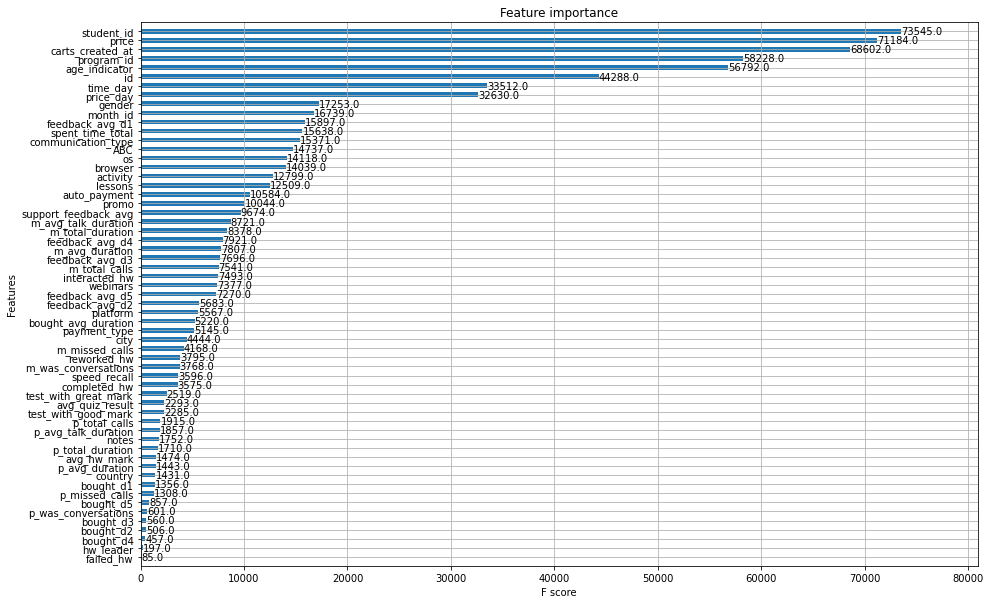

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
plot_importance(model,height=0.5, ax=ax,importance_type='weight')
plt.show()

In [51]:
threshold = np.sort(model.feature_importances_)[14:]

In [53]:
for thresh in threshold:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    X_train_s = selection.transform(X_train)
    model_select = XGBClassifier( n_estimators= 1238,
                                     max_depth= 9,
                                     learning_rate= 0.10846692523927018,
                                     subsample= 0.9,
                                     colsample_bylevel= 0.9,
                                     reg_lambda= 0.004688748882647761,
                                     reg_alpha= 0.009825482290623943,
                                     use_label_encoder=False, nthread=32,tree_method='gpu_hist')
    model_select.fit(X_train_s, y_train)
    X_test_s = selection.transform(X_val)
    predict = model_select.predict(X_test_s)
    score = (0.2* recall_score(y_val, predict, average='macro') + 0.8* precision_score(y_val, predict, average='macro'))
    print("Thresh=%.7f,score: %.5f%% " % (thresh, score))

Thresh=0.0097470,score: 0.93731% 
Thresh=0.0101413,score: 0.93862% 
Thresh=0.0101956,score: 0.94167% 
Thresh=0.0103787,score: 0.94060% 
Thresh=0.0107432,score: 0.94103% 
Thresh=0.0108315,score: 0.94141% 
Thresh=0.0109440,score: 0.93996% 
Thresh=0.0127347,score: 0.94089% 
Thresh=0.0130244,score: 0.94105% 
Thresh=0.0132321,score: 0.93905% 
Thresh=0.0135252,score: 0.94126% 
Thresh=0.0139571,score: 0.93866% 
Thresh=0.0146918,score: 0.93134% 
Thresh=0.0158009,score: 0.93449% 
Thresh=0.0161679,score: 0.91521% 
Thresh=0.0167832,score: 0.90741% 
Thresh=0.0172767,score: 0.90795% 
Thresh=0.0175228,score: 0.90850% 
Thresh=0.0176172,score: 0.90225% 
Thresh=0.0184000,score: 0.90265% 
Thresh=0.0184006,score: 0.82798% 
Thresh=0.0184983,score: 0.82945% 
Thresh=0.0185305,score: 0.81369% 
Thresh=0.0187287,score: 0.80828% 
Thresh=0.0188311,score: 0.80472% 
Thresh=0.0192299,score: 0.78530% 
Thresh=0.0201119,score: 0.76424% 
Thresh=0.0206240,score: 0.77059% 
Thresh=0.0206654,score: 0.61297% 
Thresh=0.02069

In [28]:
best=0.01019557

In [38]:
selection = SelectFromModel(model, threshold=0.01019557, prefit=True)
X_train_s = selection.transform(X)
model_s = XGBClassifier( n_estimators= 1238,
                         max_depth= 9,
                         learning_rate= 0.10846692523927018,
                         subsample= 0.9,
                         colsample_bylevel= 0.9,
                         reg_lambda= 0.004688748882647761,
                         reg_alpha= 0.009825482290623943,
                        use_label_encoder=False, nthread=32,tree_method='gpu_hist')
model_s.fit(X_train_s, y)
X_valid_s = selection.transform(X_valid)
predict = model_s.predict(X_valid_s)

In [39]:
sub['target']=predict

In [40]:
sub['target'].value_counts()

0    74903
1     5434
4     1447
5     1341
3     1218
2      654
Name: target, dtype: int64

In [41]:
sub.to_csv('submission.csv', index = False)